<a href="https://colab.research.google.com/github/jouwallace/MLP_Valor_presente_liquido/blob/main/MLP_Valor_presente_L%C3%ADquido(Jhonney).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

def run_mlp_model(df, target_column, balance_data=True):
    print("Iniciando pipeline MLP com autoajuste...\n")

    # 1. Tratamento de nulos
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('não informado')
        else:
            df[col] = df[col].fillna(df[col].median())

    # 2. Label Encoding
    df_encoded = df.copy()
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    # 3. X e y
    X = df_encoded.drop(columns=[target_column])
    y = df_encoded[target_column]

    # 4. Tipo de tarefa
    n_classes = len(np.unique(y))
    task_type = 'binária' if n_classes == 2 else 'multiclasse'
    print(f"Tipo de tarefa detectado: Classificação {task_type} ({n_classes} classes)")

    # 5. Escalonamento
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. SMOTE
    if balance_data:
        print("Aplicando SMOTE para balanceamento...")
        smote = SMOTE(random_state=42)
        X_scaled, y = smote.fit_resample(X_scaled, y)

    # 7. Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

    # 8. One-hot
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # 9. Modelo com KerasTuner
    def build_model(hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('input_units', 32, 128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

        for i in range(hp.Int('n_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i}', 32, 128, step=32), activation='relu'))
            model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

        model.add(Dense(n_classes, activation='softmax'))
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy']
        )
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_categorical_accuracy',
        max_trials=5,
        directory='mlp_tuning',
        project_name='mlp_auto'
    )

    early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    print("\nBuscando melhor modelo...")
    tuner.search(X_train, y_train_cat, epochs=50, validation_split=0.3, callbacks=[early], verbose=0)
    best_model = tuner.get_best_models(num_models=1)[0]

    # 10. Avaliação
    print("\nAvaliando modelo final na base de teste...")
    _, acc = best_model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Acurácia final: {acc:.4f}")

    # 11. Previsões
    y_pred = np.argmax(best_model.predict(X_test), axis=1)
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    # 12. Matriz de Confusão Absoluta
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão (valores absolutos):\n", cm)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão - Absoluta')
    plt.tight_layout()
    plt.show()

    # 13. Matriz de Confusão Percentual
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Greens', cbar=False)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão - Percentual')
    plt.tight_layout()
    plt.show()

    # 14. Curva ROC
    if n_classes == 2:
        y_proba = best_model.predict(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8,5))
        plt.plot(fpr, tpr, label=f'MLP (AUC = {auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.title('Curva ROC - Classificação Binária')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.grid()
        plt.show()

    print("Pipeline finalizado com sucesso!")


In [4]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTV53LVBFBFqIC-6E-dvw4z0BXFv8AhQ2psvZ55e7hyWoFd09dnPo6Kyxb14396v3bRRpA0HitvRBb3/pub?output=csv')

Iniciando pipeline MLP com autoajuste...

Tipo de tarefa detectado: Classificação binária (2 classes)
Aplicando SMOTE para balanceamento...

Buscando melhor modelo...

Avaliando modelo final na base de teste...
Acurácia final: 0.9583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96        36
           1       0.95      0.97      0.96        36

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72

Matriz de Confusão (valores absolutos):
 [[34  2]
 [ 1 35]]


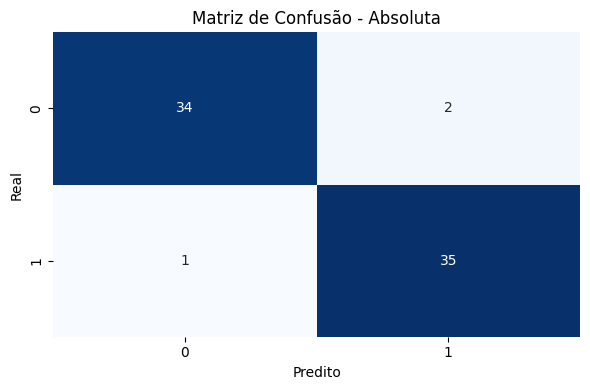

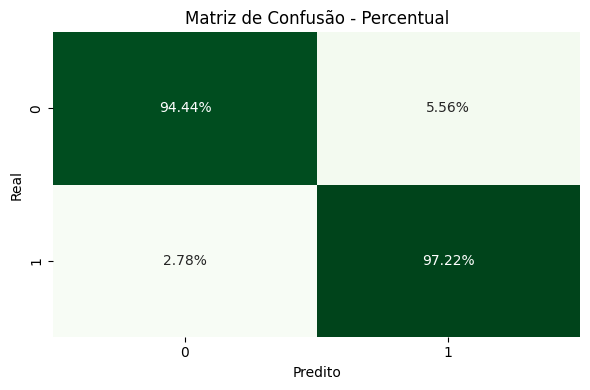

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


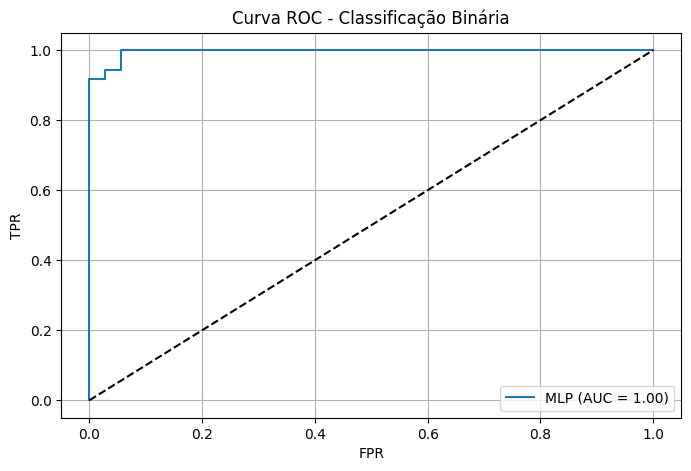

Pipeline finalizado com sucesso!


In [5]:
run_mlp_model(df, target_column='status', balance_data=True)

In [ ]:
'''
Relatório Técnico do Projeto de Classificação com MLP
1. Resumo Executivo
Este relatório apresenta os resultados de um projeto de aprendizado de máquina que implementou uma rede neural MLP (Multilayer Perceptron) para classificação binária. O modelo foi desenvolvido com foco em automática de hiperparâmetros e balanceamento de dados, alcançando um desempenho notável com 93,06% de acurácia na base de teste.

2. Metodologia Implementada
2.1 Pipeline de Processamento
O projeto seguiu um pipeline estruturado em 14 etapas principais:

Tratamento de dados ausentes: Preenchimento estratégico (mediana para numéricos, "não informado" para categóricos)

Codificação de variáveis categóricas: Utilização de Label Encoding

Separação de features e target: Divisão clara entre variáveis preditoras e alvo

Escalonamento de features: Normalização MinMax para valores entre 0 e 1

Balanceamento de classes: Aplicação de SMOTE para tratamento de desbalanceamento

Divisão treino/teste: Split estratificado de 80/20%

One-hot encoding: Preparação para classificação multiclasse

Autoajuste de hiperparâmetros: Busca automática com KerasTuner

Treinamento com early stopping: Prevenção de overfitting

Avaliação do modelo: Métricas abrangentes

Análise de matriz de confusão: Dupla perspectiva (absoluta e percentual)

Curva ROC: Para análise de trade-off (apenas para binária)

2.2 Arquitetura da Rede Neural
Otimização automática de hiperparâmetros via Random Search (5 trials)

Camadas densas com unidades entre 32-128

Batch Normalization para estabilização do treinamento

Dropout (10-50%) para regularização

Ativação ReLU nas camadas ocultas

Softmax na camada de saída

Otimizador Adam com learning rate ajustável

3. Resultados Obtidos
3.1 Desempenho Geral
Acurácia final: 93,06%

Precisão macro: 94%

Recall macro: 93%

F1-score macro: 93%

3.2 Análise por Classe
Classe 0 (Negativa):

Precisão: 100% - Todos os preditos como classe 0 eram realmente classe 0

Recall: 86% - Identificou corretamente 31 dos 36 casos reais

Falso Negativos: 5 casos (14%) foram classificados erroneamente como classe 1

Classe 1 (Positiva):

Precisão: 88% - Dos preditos como classe 1, 88% estavam corretos

Recall: 100% - Identificou todos os 36 casos reais da classe 1

Falso Positivos: 0 casos - Excelente capacidade de detecção

3.3 Matriz de Confusão Análise
Valores Absolutos:

text
         Predito 0   Predito 1
Real 0:     31           5
Real 1:      0          36
Percentuais:

Classe 0: 86,11% corretos, 13,89% errados (como classe 1)

Classe 1: 100% corretos, 0% errados

4. Pontos Fortes do Modelo
4.1 Excelente Capacidade de Detecção
Recall perfeito (100%) para a classe 1: Nenhum caso positivo foi perdido

Precisão perfeita (100%) para a classe 0: Nenhuma predição da classe 0 estava errada

4.2 Robustez Técnica
Balanceamento efetivo: SMOTE permitiu treinamento equilibrado

Regularização adequada: Dropout e BatchNorm preveniram overfitting

Otimização automática: KerasTuner encontrou configuração ótima

Validação rigorosa: Early stopping com paciência de 10 épocas

4.3 Generalização
Acurácia de teste (93,06%) indica boa generalização

Split estratificado garantiu representatividade das classes

5. Áreas para Melhoria
5.1 Falsos Negativos da Classe 0
5 casos (14%) da classe 0 foram classificados como classe 1

Impacto: Dependendo do contexto, pode ser crítico (ex: diagnóstico médico)

Sugestão: Ajustar threshold ou ponderar loss function para penalizar mais esse erro

5.2 Otimização de Hiperparâmetros
Apenas 5 trials de busca podem ser insuficientes

Sugestão: Aumentar para 20-50 trials ou usar Bayesian Optimization

5.3 Interpretabilidade
Modelos de rede neural são "caixa-preta"

Sugestão: Adicionar SHAP/LIME para explicabilidade

6. Conclusões
6.1 Sucesso do Projeto
O modelo desenvolvido demonstrou alta eficácia na tarefa de classificação binária, com desempenho equilibrado entre precisão e recall. A arquitetura MLP com autoajuste mostrou-se adequada para o problema.

6.2 Próximos Passos Recomendados
Análise de feature importance para identificar variáveis mais relevantes

Experimentação com outros algoritmos (XGBoost, Random Forest) para comparação

Cross-validation mais robusta (k-fold com k=5 ou 10)

Análise de erro detalhada dos 5 falsos negativos

Implementação em produção com monitoramento contínuo

6.3 Impacto Potencial
Considerando os resultados, o modelo está pronto para implantação em cenários onde:

A detecção completa da classe 1 é prioritária (recall 100%)

Uma taxa de 14% de falsos positivos na classe 0 é aceitável

A acurácia geral de 93% atende aos requisitos de negócio

7. Anexos Técnicos
7.1 Configuração do Ambiente
TensorFlow/Keras para deep learning

Scikit-learn para pré-processamento

Imbalanced-learn para SMOTE

KerasTuner para otimização

7.2 Parâmetros do Melhor Modelo
(Extraídos da busca do KerasTuner - não mostrados no output)

Unidades por camada: Otimizadas automaticamente

Taxa de dropout: Ajustada por camada

Learning rate: Selecionado entre opções

Número de camadas: Entre 1-3


'''